In [132]:
from functions import LoadData
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import timesfm
import matplotlib.pyplot as plt

loader = LoadData("AAPL")
stock_data = loader.load_stock_data(start_date=datetime(2018,1,1))

[*********************100%***********************]  1 of 1 completed


In [133]:
target = 'Close'
close_price = stock_data[target].values
scaler = MinMaxScaler()
close_price = scaler.fit_transform(close_price.reshape(-1, 1))

In [134]:
def reshape_vars_seperate(var, num_sequences=50):
    seq_length = len(var) // num_sequences
    reshaped = var[:num_sequences * seq_length].reshape(num_sequences, seq_length)

    y_train_seq = reshaped[:,:-1]
    y_test_seq = reshaped[:,-1]

    return y_train_seq, y_test_seq
close_price_train_seq, close_price_test_seq = reshape_vars_seperate(close_price)
print("Reshaped close_price_train_seq:", close_price_train_seq.shape)
print("Testing Values Shape:", close_price_test_seq.shape)


Reshaped close_price_train_seq: (50, 35)
Testing Values Shape: (50,)


In [135]:
train_dates, test_dates= reshape_vars_seperate(stock_data.index.values)    

In [136]:
device = "cpu"  # or "cuda" if you have a GPU
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="pytorch",
          per_core_batch_size=32,
          horizon_len=1,
          input_patch_len=32,
          output_patch_len=128,
          num_layers=50,
          model_dims=1280,
          use_positional_embedding=False,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [137]:
close_price_pred, x = tfm.forecast(close_price_train_seq)

In [138]:
np.sqrt(np.mean((close_price_pred - close_price_test_seq) ** 2))

np.float64(0.3829833457424311)

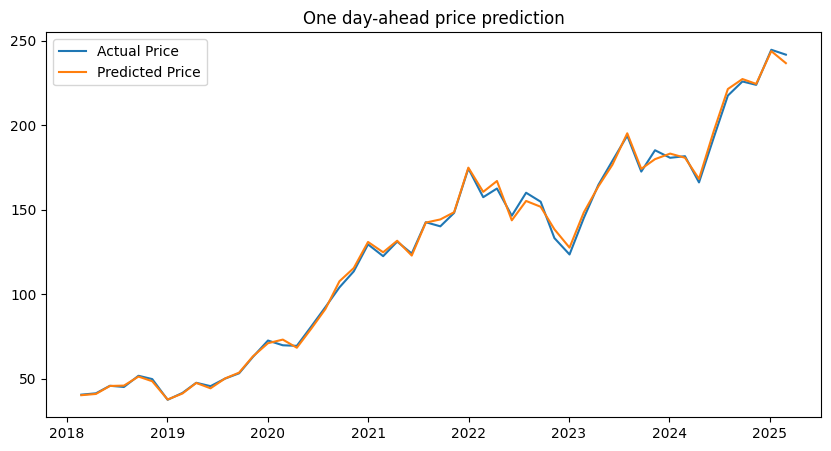

In [ ]:
# Convert back to original scale
predicted_stock_price = scaler.inverse_transform(close_price_pred)
actual_stock_price = scaler.inverse_transform(close_price_test_seq.reshape(-1, 1))

plt.figure(figsize=(10,5))
plt.plot(test_dates, actual_stock_price, label="Actual Price")
plt.plot(test_dates,predicted_stock_price, label="Predicted Price")
plt.title("One day-ahead price prediction")
plt.legend()
plt.show()


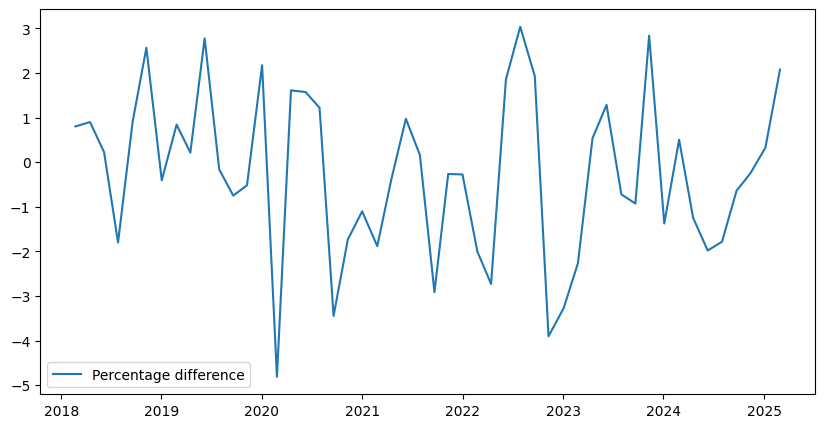

In [140]:
plt.figure(figsize=(10,5))
plt.plot(test_dates, 100*(actual_stock_price-predicted_stock_price)/actual_stock_price, label="Percentage difference")
plt.legend()
plt.show()


In [141]:
stock_data["change"]=100*(stock_data["Close"]-stock_data["Close"].shift(1))/stock_data["Close"]
stock_data.dropna(inplace=True)
target = 'change'
change = stock_data[target].values
change = scaler.fit_transform(change.reshape(-1, 1))
change_train_seq, change_test_seq = reshape_vars_seperate(change)

In [142]:
change_pred, x = tfm.forecast(change_train_seq)

In [143]:
np.sqrt(np.mean((change_pred - change_test_seq) ** 2))

np.float64(0.10231546870495929)

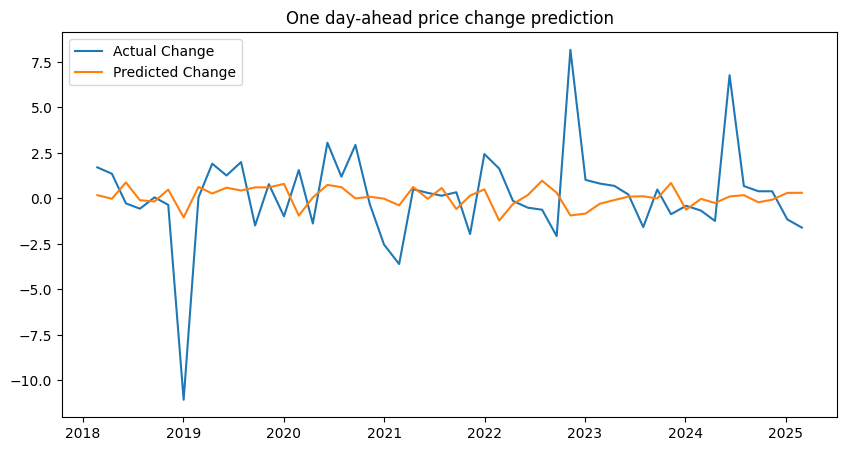

In [ ]:
predicted_price_change = scaler.inverse_transform(change_pred)
actual_price_change = scaler.inverse_transform(change_test_seq.reshape(-1, 1))

plt.figure(figsize=(10,5))
plt.plot(test_dates, actual_price_change, label="Actual Change")
plt.plot(test_dates, predicted_price_change, label="Predicted Change")
plt.title("One day-ahead price change prediction")
plt.legend()
plt.show()


In [168]:
def reshape_vars_sliding(
    var,
    dates
    sequence_len= 50
):
    var = var.flatten()  
    num_sequences = len(var) - sequence_len

    sequences = np.zeros((num_sequences, sequence_len))
    targets = np.zeros(num_sequences)
    target_dates = np.empty(num_sequences, dtype=object)

    for i in range(num_sequences):
        sequences[i] = var[i:i + sequence_len]
        targets[i] = var[i + sequence_len]
        target_dates[i] = dates[i + sequence_len]

    return sequences, targets, target_dates


In [169]:
change_train_sliding, change_test_sliding, dates_test_sliding = reshape_vars_sliding(change, stock_data.index.values)

In [172]:
change_pred_sliding, x = tfm.forecast(change_train_sliding)

In [178]:
np.sqrt(np.mean((change_pred_sliding - change_test_sliding) ** 2))

np.float64(0.07837553485487476)

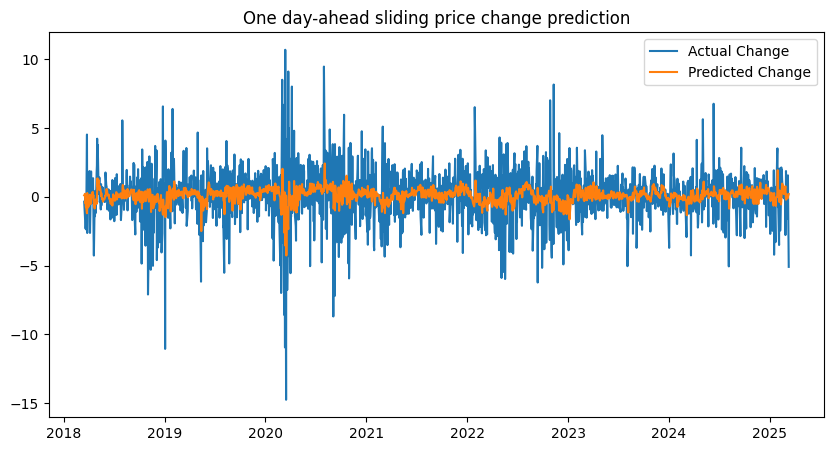

In [177]:
predicted_price_change_sliding = scaler.inverse_transform(change_pred_sliding)
actual_price_change_sliding = scaler.inverse_transform(change_test_sliding.reshape(-1, 1))

plt.figure(figsize=(10,5))
plt.plot(dates_test_sliding, actual_price_change_sliding, label="Actual Change")
plt.plot(dates_test_sliding  , predicted_price_change_sliding, label="Predicted Change")
plt.title("One day-ahead sliding price change prediction")
plt.legend()
plt.show()
